# Denoising Diffusion Probabilistic Models (DDPM)

> This notebook is a PyTorch implementation of the Denoising Diffusion Probabilistic Models (DDPM) proposed in the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) by Jonathan Ho, Ajay Jain, Pieter Abbeel.

## Materials

- [DDPM: Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)

- [Understanding Diffusion Models: A Unified Perspective](https://arxiv.org/abs/2208.11970) 

- [Lecture of Hung-yi Lee](https://www.youtube.com/watch?v=azBugJzmz-o)

## Model Overview

> Given a picture, keep adding noise for N steps until it was "masked", then use networks to predict the noise at every step and dig out the original picture.


However, it is where the **inconsistency** occurs: 

**In implement, autually we don't add noise on the last noised picture but rather directly on the original picture.**

## Basic Definitions

### ELBO (Evidence Lower Bound)

> The measure of how well the model is doing.

Let $p^*(x)$ be the distribution of the data, our goal is to maximize our estimate likelihood $p(x)$. However, it is hard to compute the likelihood directly, so we use the ELBO instead.

$z$ is the latent variable of the data distribution, and we use some models like network with parameter $\Phi$ to get the estimate.

![procedure](image-1.png)

![ELBO](image.png)

Having introduced latent variables $z$ that we would like to model, our goal is to learn this underlying latent structure that describes our observed data. In other words, we want to optimize the parameters of our variational posterior $q_{\Phi}(z|x)$ to exactly match the true posterior distribution $p(z|x)$, which is achieved by minimizing their KL Divergence (ideally to zero).

Given a constant parameter $\Phi$, the estimate of the $p(x)$ is also fixed, so we can maximize the ELBO to minimize the KL Divergence, which is our goal.

### VAE (Variational Autoencoders)

![VAE](image-2.png)

### MHVAE (Markovian Hierarchical Variational Autoencoders)

![MHVAE](image-3.png)

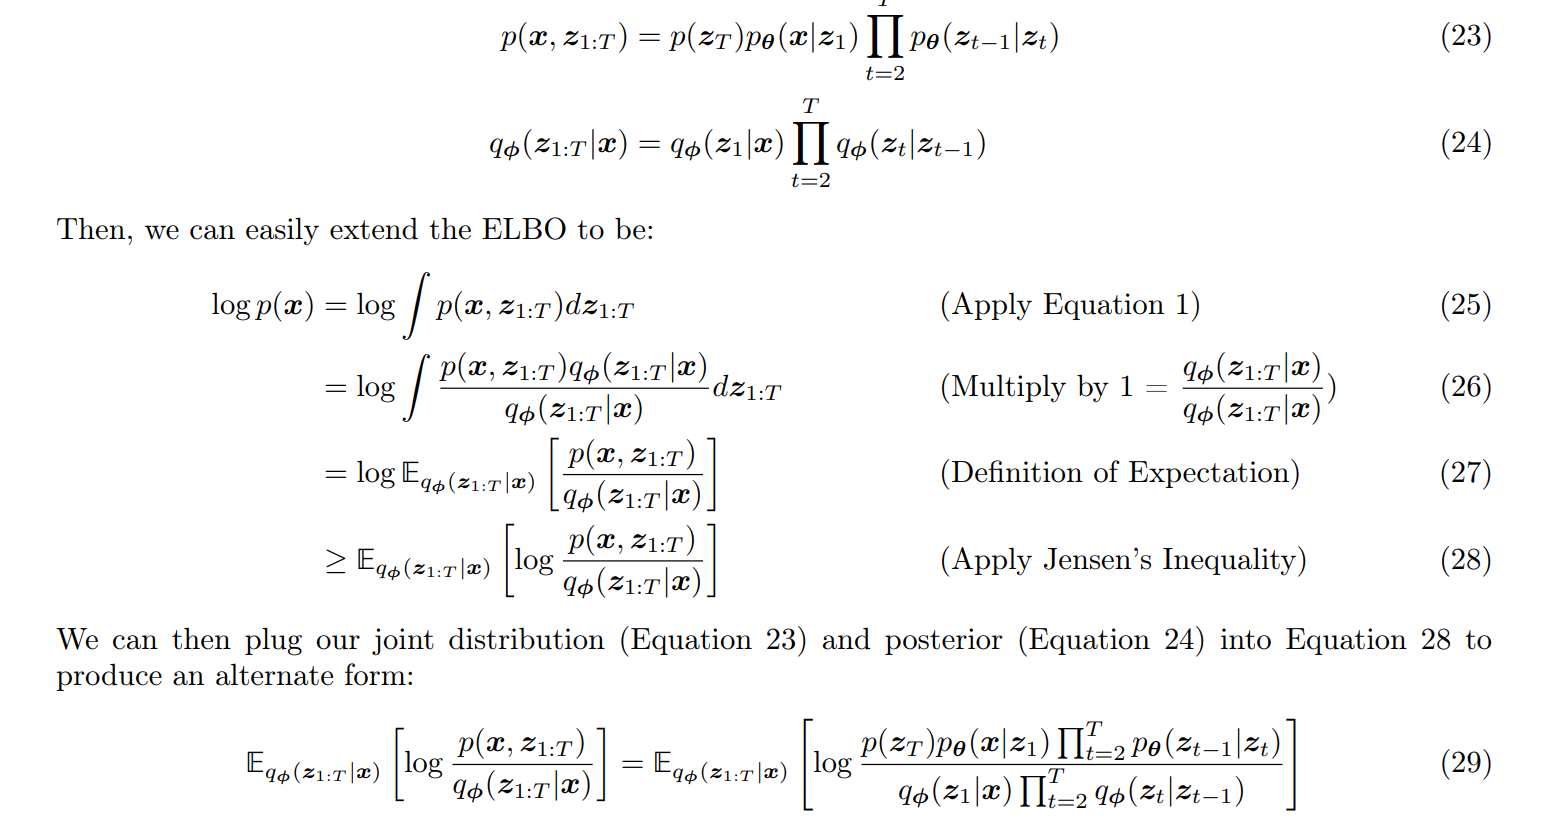

## DDPM

> Similar to a Markovian Hierarchical Variational Autoencoder with three key restrictions
>
> - The latent dimension is exactly equal to the data dimension
>
> - The structure of the latent encoder at each timestep is a pre-defined linear Gaussian model, centered around the output of the previous timestep.
>
> - The distribution of the latent at final timestep T is a standard Gaussian

![DDPM](image-4.png)

![xt](image-5.png)

![alt text](image-6.png)

In [ ]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

Type = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print("Using", Type)

In [ ]:
# Input data from photo2stylegan
from torchvision import datasets, transforms
from PIL import Image
path = "photo2style/trainA"

train_data_N = 400
size = 64
train_data = []
transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor()
])
for i in range(1, train_data_N + 1):
    img = Image.open(f"{path}/%05d.jpg"%i).convert('RGB')
    img = transform(img)
    # img = img.transpose(2, 0, 1)
    train_data.append(img)

train_data = np.array(train_data)
print("train_data shape:", train_data[0].shape)
sample = train_data[random.randint(0, train_data_N - 1)]
plt.imshow(sample.transpose(1, 2, 0))

# make batches
batch_size = 16
train_data = torch.tensor(train_data)
train_data = train_data[:train_data.shape[0] // batch_size * batch_size]
train_data = train_data.view(-1, batch_size, 3, size, size)
print("train_data shape:", train_data.shape)

In [ ]:
# load data from mnist
import torchvision
from torchvision import transforms

size = 32
batch_size = 128

transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor()
])
mnist = torchvision.datasets.MNIST(root="mnist", train=True, transform=transform, download=True)
mnist = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)

train_data = [x for x, _ in mnist]

sample = train_data[random.randint(0, len(train_data) - 1)]
print(sample.shape)
plt.imshow(sample[0][0])

In [ ]:
# DDPM parameters

T = 200
beta = np.linspace(1e-4, 0.02, T)
beta = np.array([0] + list(beta))
alpha = 1.0 - beta
alpha_bar = np.cumprod(alpha)

alpha_sqrt = np.sqrt(alpha_bar)
alpha_bar_sqrt = np.sqrt(1 - alpha_bar)

beta = torch.tensor(beta).type(Type)
alpha_bar = torch.tensor(alpha_bar).type(Type)
alpha_sqrt = torch.tensor(alpha_sqrt).type(Type)
alpha_bar_sqrt = torch.tensor(alpha_bar_sqrt).type(Type)

print("alpha_sqrt:", alpha_sqrt)
print("alpha_bar_sqrt:", alpha_bar_sqrt)

In [ ]:
# Step embbeding using Sinusoidal time embeddings
def Step_Emb(step, x):
    emb = np.ones((x.shape[2], x.shape[3])) * np.cos(1.0 * step / T * np.pi)
    emb = torch.tensor(emb).type(Type)
    emb = emb.unsqueeze(0).unsqueeze(0)
    emb = emb.expand((x.shape[0], 1, -1, -1))
    return torch.cat((x, emb), dim=1)

In [ ]:
# noise add
def Add_Noise(x, step):
    noise = torch.randn_like(x)
    return noise, alpha_sqrt[step] * x + alpha_bar_sqrt[step] * noise

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.bn = nn.BatchNorm2d(in_channels)

        self.conv1 = nn.Conv2d(in_channels, 64, 3, 1, 1)
        self.F1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.F2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.F3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1)
        self.F4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(128, 256, 3, 1, 1)
        self.F5 = nn.ReLU()
        self.conv6 = nn.Conv2d(256, 256, 3, 1, 1)
        self.F6 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv7 = nn.Conv2d(256, 512, 3, 1, 1)
        self.F7 = nn.ReLU()
        self.conv8 = nn.Conv2d(512, 512, 3, 1, 1)
        self.F8 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv9 = nn.Conv2d(512, 1024, 3, 1, 1)
        self.F9 = nn.ReLU()

        self.up1 = nn.ConvTranspose2d(1024, 512, 2, 2)

        self.conv10 = nn.Conv2d(1024, 512, 3, 1, 1)
        self.F10 = nn.ReLU()
        self.conv11 = nn.Conv2d(512, 512, 3, 1, 1)
        self.F11 = nn.ReLU()

        self.up2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.conv12 = nn.Conv2d(512, 256, 3, 1, 1)
        self.F12 = nn.ReLU()
        self.conv13 = nn.Conv2d(256, 256, 3, 1, 1)
        self.F13 = nn.ReLU()

        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv14 = nn.Conv2d(256, 128, 3, 1, 1)
        self.F14 = nn.ReLU()
        self.conv15 = nn.Conv2d(128, 128, 3, 1, 1)
        self.F15 = nn.ReLU()

        self.up4 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv16 = nn.Conv2d(128, 64, 3, 1, 1)
        self.F16 = nn.ReLU()
        self.conv17 = nn.Conv2d(64, 64, 3, 1, 1)
        self.F17 = nn.ReLU()

        self.conv18 = nn.Conv2d(64, out_channels, 1, 1, 0)
    
    def forward(self, x):
        # print(x.shape)
        x = self.bn(x)
        x = self.conv1(x)
        x = self.F1(x)
        x = self.conv2(x)
        x = self.F2(x)
        x1 = x
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.F3(x)
        x = self.conv4(x)
        x = self.F4(x)
        x2 = x
        x = self.pool2(x)

        x = self.conv5(x)
        x = self.F5(x)
        x = self.conv6(x)
        x = self.F6(x)
        x3 = x
        x = self.pool3(x)

        x = self.conv7(x)
        x = self.F7(x)
        x = self.conv8(x)
        x = self.F8(x)
        x4 = x
        x = self.pool4(x)

        x = self.conv9(x)
        x = self.F9(x)

        x = self.up1(x)
        x = torch.cat((x, x4), 1)
        x = self.conv10(x)
        x = self.F10(x)
        x = self.conv11(x)
        x = self.F11(x)

        x = self.up2(x)
        x = torch.cat((x, x3), 1)
        x = self.conv12(x)
        x = self.F12(x)
        x = self.conv13(x)
        x = self.F13(x)

        x = self.up3(x)
        x = torch.cat((x, x2), 1)
        x = self.conv14(x)
        x = self.F14(x)
        x = self.conv15(x)
        x = self.F15(x)

        x = self.up4(x)
        x = torch.cat((x, x1), 1)
        x = self.conv16(x)
        x = self.F16(x)
        x = self.conv17(x)
        x = self.F17(x)

        x = self.conv18(x)
        return x


def predict(x, model):
    wid = 1.5
    patch = 10
    plt.figure(figsize=(T // patch * wid + wid, wid))
    plt.subplot(1, T // patch + 1, T // patch + 1)
    plt.imshow(x[0].detach().cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')
    
    for t in range(T, 0, -1):
        eps = model(Step_Emb(t, x))
        x = 1.0 / alpha[t] * (x - beta[t] / alpha_bar_sqrt[t] * eps)
        if t != 1:
            x += torch.sqrt(beta[t]  * (1.0 - alpha_bar[t - 1]) / (1.0 - alpha_bar[t])) * torch.randn_like(x)

        if t % 5 == 1:
            plt.subplot(1, T // patch + 1, t // patch + 1)
            plt.imshow(x[0].detach().cpu().numpy().transpose(1, 2, 0))
            plt.axis('off')
    
    plt.show()
    return x

In [ ]:
input_channels = 1
model = Unet(input_channels + 1, input_channels).type(Type)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-6)

epoch: 82 batch: 265 | loss: 0.025566421449184418
epoch: 82 batch: 266 | loss: 0.014645358547568321
epoch: 82 batch: 267 | loss: 0.010667766444385052
epoch: 82 batch: 268 | loss: 0.016097629442811012
epoch: 82 batch: 269 | loss: 0.019174249842762947
epoch: 82 batch: 270 | loss: 0.062495265156030655
epoch: 82 batch: 271 | loss: 0.019113289192318916
epoch: 82 batch: 272 | loss: 0.044262662529945374
epoch: 82 batch: 273 | loss: 0.02481761947274208
epoch: 82 batch: 274 | loss: 0.01906927302479744
epoch: 82 batch: 275 | loss: 0.02227836847305298
epoch: 82 batch: 276 | loss: 0.012131370604038239
epoch: 82 batch: 277 | loss: 0.019198598340153694
epoch: 82 batch: 278 | loss: 0.01320861466228962
epoch: 82 batch: 279 | loss: 0.05583757162094116
epoch: 82 batch: 280 | loss: 0.022725485265254974
epoch: 82 batch: 281 | loss: 0.02216401696205139
epoch: 82 batch: 282 | loss: 0.013545596972107887
epoch: 82 batch: 283 | loss: 0.024180036038160324
epoch: 82 batch: 284 | loss: 0.024764003232121468
epoch:

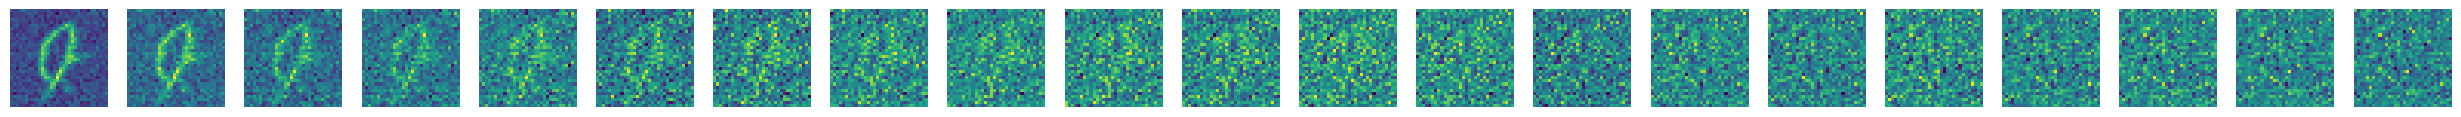

epoch: 83 batch: 1 | loss: 0.04306095466017723
epoch: 83 batch: 2 | loss: 0.009160969406366348
epoch: 83 batch: 3 | loss: 0.021802371367812157
epoch: 83 batch: 4 | loss: 0.03561308979988098
epoch: 83 batch: 5 | loss: 0.011056224815547466
epoch: 83 batch: 6 | loss: 0.01151966117322445
epoch: 83 batch: 7 | loss: 0.01482581440359354
epoch: 83 batch: 8 | loss: 0.00962747074663639
epoch: 83 batch: 9 | loss: 0.018421266227960587
epoch: 83 batch: 10 | loss: 0.04047231376171112
epoch: 83 batch: 11 | loss: 0.03841213881969452
epoch: 83 batch: 12 | loss: 0.010997333563864231
epoch: 83 batch: 13 | loss: 0.013003800064325333
epoch: 83 batch: 14 | loss: 0.012554822489619255
epoch: 83 batch: 15 | loss: 0.017263971269130707
epoch: 83 batch: 16 | loss: 0.023040495812892914
epoch: 83 batch: 17 | loss: 0.009916291572153568
epoch: 83 batch: 18 | loss: 0.01239288691431284
epoch: 83 batch: 19 | loss: 0.009840330109000206
epoch: 83 batch: 20 | loss: 0.02469266951084137
epoch: 83 batch: 21 | loss: 0.01391175

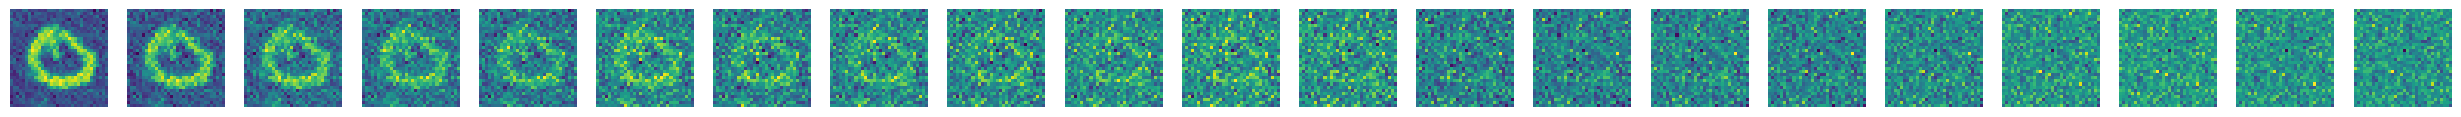

epoch: 84 batch: 1 | loss: 0.014214584603905678
epoch: 84 batch: 2 | loss: 0.03265279158949852
epoch: 84 batch: 3 | loss: 0.014502678997814655
epoch: 84 batch: 4 | loss: 0.0635816901922226
epoch: 84 batch: 5 | loss: 0.012770263478159904
epoch: 84 batch: 6 | loss: 0.024054240435361862
epoch: 84 batch: 7 | loss: 0.024436509236693382
epoch: 84 batch: 8 | loss: 0.008478110656142235
epoch: 84 batch: 9 | loss: 0.02687634900212288
epoch: 84 batch: 10 | loss: 0.02799864672124386
epoch: 84 batch: 11 | loss: 0.021148046478629112
epoch: 84 batch: 12 | loss: 0.022292383015155792
epoch: 84 batch: 13 | loss: 0.03800300508737564
epoch: 84 batch: 14 | loss: 0.008797512389719486
epoch: 84 batch: 15 | loss: 0.015109711326658726
epoch: 84 batch: 16 | loss: 0.01831933483481407
epoch: 84 batch: 17 | loss: 0.017638277262449265
epoch: 84 batch: 18 | loss: 0.017968585714697838
epoch: 84 batch: 19 | loss: 0.02778506651520729
epoch: 84 batch: 20 | loss: 0.017914094030857086
epoch: 84 batch: 21 | loss: 0.0354107

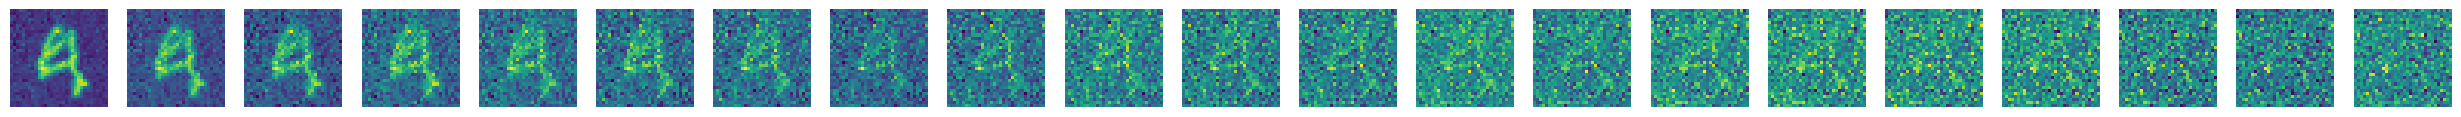

epoch: 85 batch: 1 | loss: 0.13622665405273438
epoch: 85 batch: 2 | loss: 0.01980658434331417
epoch: 85 batch: 3 | loss: 0.015504902228713036
epoch: 85 batch: 4 | loss: 0.021238267421722412
epoch: 85 batch: 5 | loss: 0.011534489691257477
epoch: 85 batch: 6 | loss: 0.07763418555259705
epoch: 85 batch: 7 | loss: 0.09077894687652588
epoch: 85 batch: 8 | loss: 0.016040587797760963
epoch: 85 batch: 9 | loss: 0.01579437404870987
epoch: 85 batch: 10 | loss: 0.015317991375923157
epoch: 85 batch: 11 | loss: 0.008661715313792229
epoch: 85 batch: 12 | loss: 0.03313498944044113
epoch: 85 batch: 13 | loss: 0.01661573350429535
epoch: 85 batch: 14 | loss: 0.012529050931334496
epoch: 85 batch: 15 | loss: 0.013175329193472862
epoch: 85 batch: 16 | loss: 0.024278458207845688
epoch: 85 batch: 17 | loss: 0.016998648643493652
epoch: 85 batch: 18 | loss: 0.02218272164463997
epoch: 85 batch: 19 | loss: 0.08684156835079193
epoch: 85 batch: 20 | loss: 0.07218033075332642
epoch: 85 batch: 21 | loss: 0.028797399

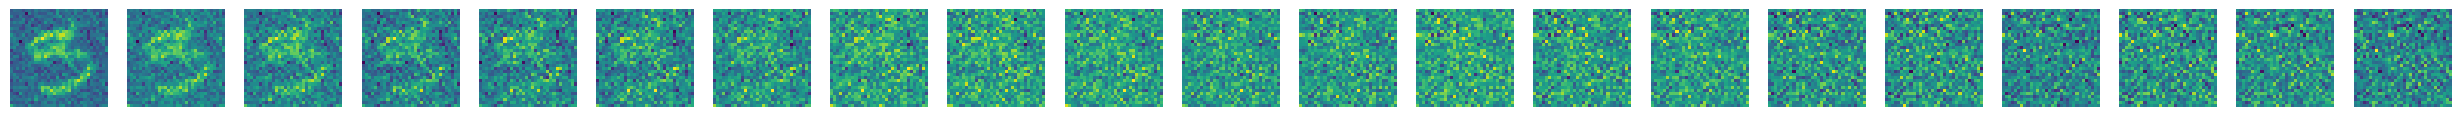

epoch: 86 batch: 1 | loss: 0.020937573164701462
epoch: 86 batch: 2 | loss: 0.019876845180988312
epoch: 86 batch: 3 | loss: 0.011961111798882484
epoch: 86 batch: 4 | loss: 0.016308926045894623
epoch: 86 batch: 5 | loss: 0.016652587801218033
epoch: 86 batch: 6 | loss: 0.017935924232006073
epoch: 86 batch: 7 | loss: 0.02468586340546608
epoch: 86 batch: 8 | loss: 0.02785005420446396
epoch: 86 batch: 9 | loss: 0.016100691631436348
epoch: 86 batch: 10 | loss: 0.04080856591463089
epoch: 86 batch: 11 | loss: 0.012083221226930618
epoch: 86 batch: 12 | loss: 0.011006107553839684
epoch: 86 batch: 13 | loss: 0.01886470429599285
epoch: 86 batch: 14 | loss: 0.02084585279226303
epoch: 86 batch: 15 | loss: 0.013917578384280205
epoch: 86 batch: 16 | loss: 0.0434664785861969
epoch: 86 batch: 17 | loss: 0.030813951045274734
epoch: 86 batch: 18 | loss: 0.025082051753997803
epoch: 86 batch: 19 | loss: 0.009669888764619827
epoch: 86 batch: 20 | loss: 0.013812695629894733
epoch: 86 batch: 21 | loss: 0.025278

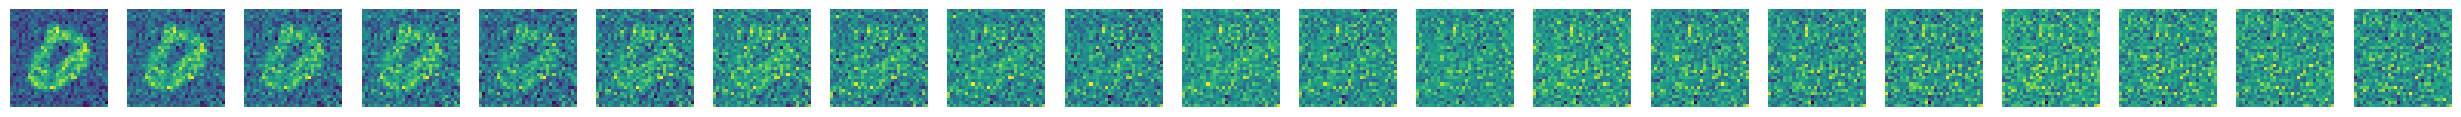

epoch: 87 batch: 1 | loss: 0.049767665565013885
epoch: 87 batch: 2 | loss: 0.015798885375261307
epoch: 87 batch: 3 | loss: 0.02852407470345497
epoch: 87 batch: 4 | loss: 0.01638685166835785
epoch: 87 batch: 5 | loss: 0.012534026987850666
epoch: 87 batch: 6 | loss: 0.0171918086707592
epoch: 87 batch: 7 | loss: 0.0359901562333107
epoch: 87 batch: 8 | loss: 0.07615318894386292
epoch: 87 batch: 9 | loss: 0.02860143594443798
epoch: 87 batch: 10 | loss: 0.03323350474238396
epoch: 87 batch: 11 | loss: 0.020671337842941284
epoch: 87 batch: 12 | loss: 0.020753854885697365
epoch: 87 batch: 13 | loss: 0.018535654991865158
epoch: 87 batch: 14 | loss: 0.015592179261147976
epoch: 87 batch: 15 | loss: 0.033003099262714386
epoch: 87 batch: 16 | loss: 0.011826101690530777
epoch: 87 batch: 17 | loss: 0.02223183400928974
epoch: 87 batch: 18 | loss: 0.028525181114673615
epoch: 87 batch: 19 | loss: 0.022231515496969223
epoch: 87 batch: 20 | loss: 0.010167279280722141
epoch: 87 batch: 21 | loss: 0.016815112

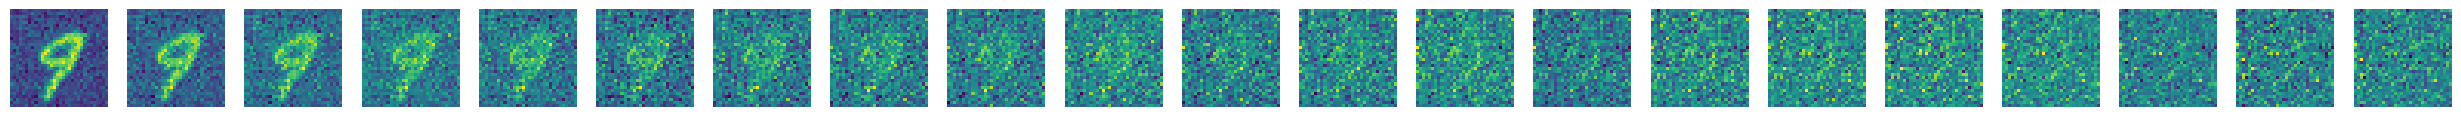

epoch: 88 batch: 1 | loss: 0.009380554780364037
epoch: 88 batch: 2 | loss: 0.011449933983385563
epoch: 88 batch: 3 | loss: 0.01078794989734888
epoch: 88 batch: 4 | loss: 0.015589323826134205
epoch: 88 batch: 5 | loss: 0.04660376161336899
epoch: 88 batch: 6 | loss: 0.07609280198812485
epoch: 88 batch: 7 | loss: 0.02108209952712059
epoch: 88 batch: 8 | loss: 0.04008936136960983
epoch: 88 batch: 9 | loss: 0.01063884049654007
epoch: 88 batch: 10 | loss: 0.03273949772119522
epoch: 88 batch: 11 | loss: 0.02770383283495903
epoch: 88 batch: 12 | loss: 0.02062031254172325
epoch: 88 batch: 13 | loss: 0.01863420009613037
epoch: 88 batch: 14 | loss: 0.01911916583776474
epoch: 88 batch: 15 | loss: 0.010902255773544312
epoch: 88 batch: 16 | loss: 0.036886729300022125
epoch: 88 batch: 17 | loss: 0.018425805494189262
epoch: 88 batch: 18 | loss: 0.015654921531677246
epoch: 88 batch: 19 | loss: 0.022069932892918587
epoch: 88 batch: 20 | loss: 0.011503200978040695
epoch: 88 batch: 21 | loss: 0.0285399705

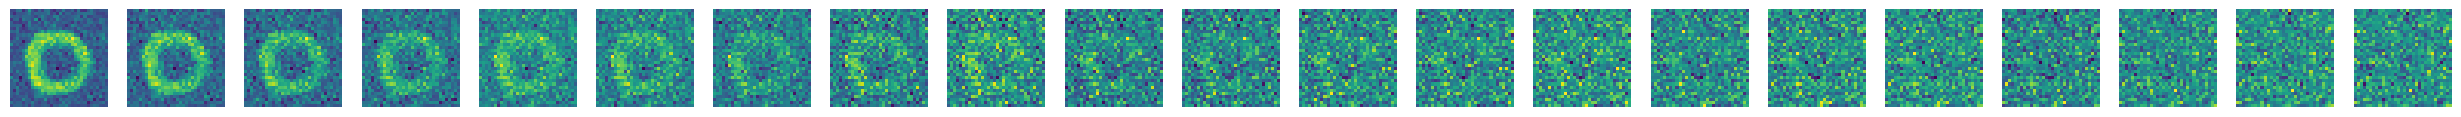

epoch: 89 batch: 1 | loss: 0.014964988455176353
epoch: 89 batch: 2 | loss: 0.016975145787000656
epoch: 89 batch: 3 | loss: 0.06767675280570984
epoch: 89 batch: 4 | loss: 0.03957230970263481
epoch: 89 batch: 5 | loss: 0.023507442325353622
epoch: 89 batch: 6 | loss: 0.014130208641290665
epoch: 89 batch: 7 | loss: 0.010655485093593597
epoch: 89 batch: 8 | loss: 0.017656613141298294
epoch: 89 batch: 9 | loss: 0.011751010082662106
epoch: 89 batch: 10 | loss: 0.019083112478256226
epoch: 89 batch: 11 | loss: 0.0479411780834198
epoch: 89 batch: 12 | loss: 0.010703451000154018
epoch: 89 batch: 13 | loss: 0.0379251204431057
epoch: 89 batch: 14 | loss: 0.01201230101287365
epoch: 89 batch: 15 | loss: 0.011361341923475266
epoch: 89 batch: 16 | loss: 0.02578422799706459
epoch: 89 batch: 17 | loss: 0.013082738034427166
epoch: 89 batch: 18 | loss: 0.019846294075250626
epoch: 89 batch: 19 | loss: 0.01687060482800007
epoch: 89 batch: 20 | loss: 0.07287852466106415
epoch: 89 batch: 21 | loss: 0.013901263

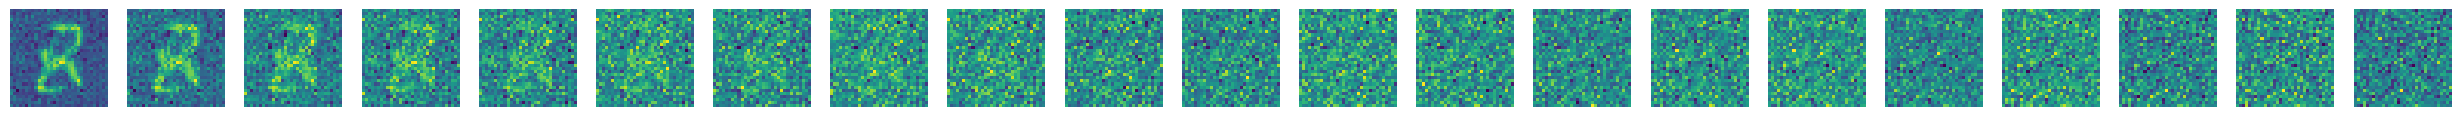

epoch: 90 batch: 1 | loss: 0.014912581071257591
epoch: 90 batch: 2 | loss: 0.016728095710277557
epoch: 90 batch: 3 | loss: 0.023597352206707
epoch: 90 batch: 4 | loss: 0.009086190722882748
epoch: 90 batch: 5 | loss: 0.01254710741341114
epoch: 90 batch: 6 | loss: 0.026760220527648926
epoch: 90 batch: 7 | loss: 0.01018616184592247
epoch: 90 batch: 8 | loss: 0.019879726693034172
epoch: 90 batch: 9 | loss: 0.01627781242132187
epoch: 90 batch: 10 | loss: 0.020115721970796585
epoch: 90 batch: 11 | loss: 0.012927312403917313
epoch: 90 batch: 12 | loss: 0.022567836567759514
epoch: 90 batch: 13 | loss: 0.014867346733808517
epoch: 90 batch: 14 | loss: 0.009991666302084923
epoch: 90 batch: 15 | loss: 0.012221083976328373
epoch: 90 batch: 16 | loss: 0.025549743324518204
epoch: 90 batch: 17 | loss: 0.013971894048154354
epoch: 90 batch: 18 | loss: 0.03327196091413498
epoch: 90 batch: 19 | loss: 0.01929740235209465
epoch: 90 batch: 20 | loss: 0.011935010552406311
epoch: 90 batch: 21 | loss: 0.0179103

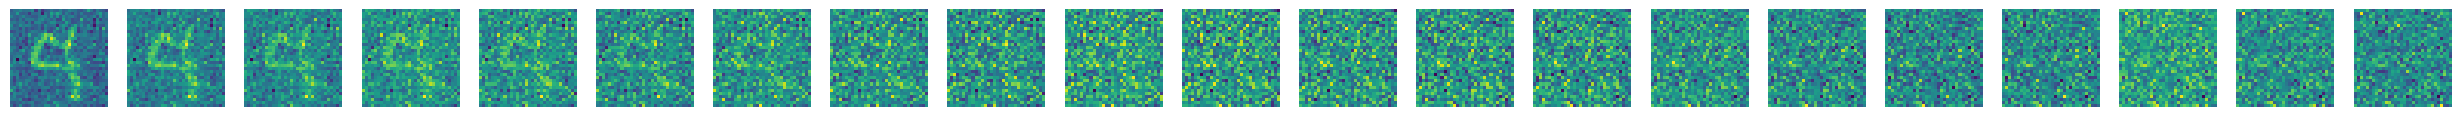

epoch: 91 batch: 1 | loss: 0.01877046376466751
epoch: 91 batch: 2 | loss: 0.025782180950045586
epoch: 91 batch: 3 | loss: 0.013630188070237637
epoch: 91 batch: 4 | loss: 0.012739568948745728
epoch: 91 batch: 5 | loss: 0.010811238549649715
epoch: 91 batch: 6 | loss: 0.011958012357354164
epoch: 91 batch: 7 | loss: 0.16072115302085876
epoch: 91 batch: 8 | loss: 0.013549553230404854
epoch: 91 batch: 9 | loss: 0.0867944061756134
epoch: 91 batch: 10 | loss: 0.01686285063624382
epoch: 91 batch: 11 | loss: 0.015377276577055454
epoch: 91 batch: 12 | loss: 0.014021104201674461
epoch: 91 batch: 13 | loss: 0.020293325185775757
epoch: 91 batch: 14 | loss: 0.020363423973321915
epoch: 91 batch: 15 | loss: 0.016242757439613342
epoch: 91 batch: 16 | loss: 0.011938657611608505
epoch: 91 batch: 17 | loss: 0.020161759108304977
epoch: 91 batch: 18 | loss: 0.01586088538169861
epoch: 91 batch: 19 | loss: 0.020155351608991623
epoch: 91 batch: 20 | loss: 0.008947642520070076
epoch: 91 batch: 21 | loss: 0.00996

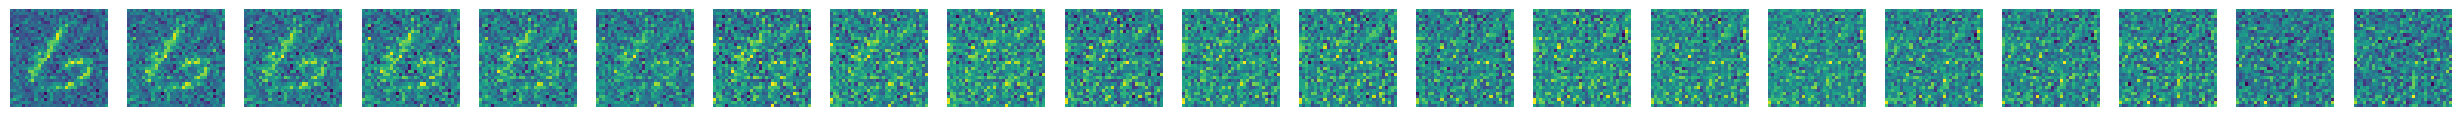

epoch: 92 batch: 1 | loss: 0.02776135876774788
epoch: 92 batch: 2 | loss: 0.03096998855471611
epoch: 92 batch: 3 | loss: 0.0188230499625206
epoch: 92 batch: 4 | loss: 0.025960572063922882
epoch: 92 batch: 5 | loss: 0.02042611874639988
epoch: 92 batch: 6 | loss: 0.02341170608997345
epoch: 92 batch: 7 | loss: 0.02552797831594944
epoch: 92 batch: 8 | loss: 0.0645526796579361
epoch: 92 batch: 9 | loss: 0.023660343140363693
epoch: 92 batch: 10 | loss: 0.028100207448005676
epoch: 92 batch: 11 | loss: 0.01663779467344284
epoch: 92 batch: 12 | loss: 0.01848376728594303
epoch: 92 batch: 13 | loss: 0.012493927031755447
epoch: 92 batch: 14 | loss: 0.010645497590303421
epoch: 92 batch: 15 | loss: 0.019826501607894897
epoch: 92 batch: 16 | loss: 0.01952340267598629
epoch: 92 batch: 17 | loss: 0.02360421046614647
epoch: 92 batch: 18 | loss: 0.010035657323896885
epoch: 92 batch: 19 | loss: 0.021709544584155083
epoch: 92 batch: 20 | loss: 0.0746414065361023
epoch: 92 batch: 21 | loss: 0.01873920485377

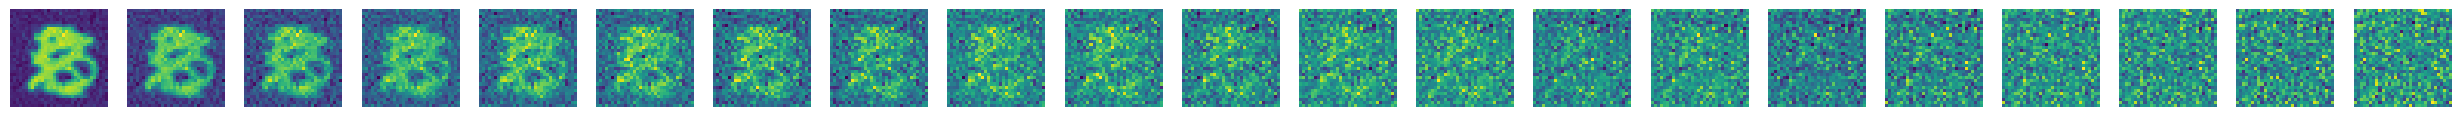

epoch: 93 batch: 1 | loss: 0.01814727485179901
epoch: 93 batch: 2 | loss: 0.02145964279770851
epoch: 93 batch: 3 | loss: 0.02021842822432518
epoch: 93 batch: 4 | loss: 0.0242071021348238
epoch: 93 batch: 5 | loss: 0.008721746504306793
epoch: 93 batch: 6 | loss: 0.02090805023908615
epoch: 93 batch: 7 | loss: 0.011213417164981365
epoch: 93 batch: 8 | loss: 0.126122385263443
epoch: 93 batch: 9 | loss: 0.022372927516698837
epoch: 93 batch: 10 | loss: 0.04123566672205925
epoch: 93 batch: 11 | loss: 0.01484440267086029
epoch: 93 batch: 12 | loss: 0.022996537387371063
epoch: 93 batch: 13 | loss: 0.01797352358698845
epoch: 93 batch: 14 | loss: 0.03531637787818909
epoch: 93 batch: 15 | loss: 0.022399134933948517
epoch: 93 batch: 16 | loss: 0.03346243128180504
epoch: 93 batch: 17 | loss: 0.014545300975441933
epoch: 93 batch: 18 | loss: 0.009990707971155643
epoch: 93 batch: 19 | loss: 0.017006926238536835
epoch: 93 batch: 20 | loss: 0.03792775049805641
epoch: 93 batch: 21 | loss: 0.03233564272522

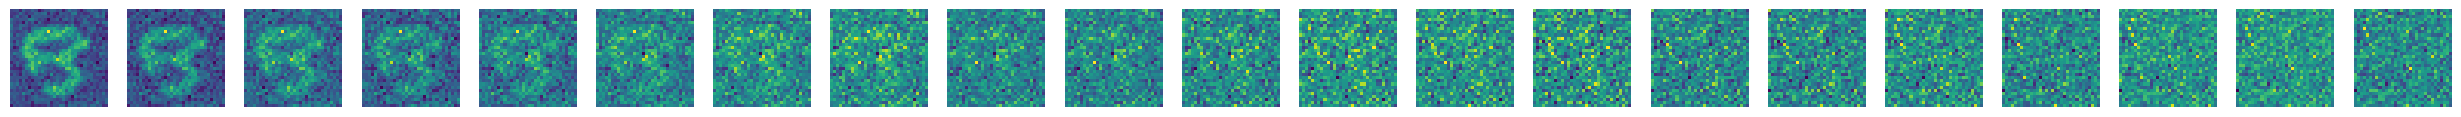

epoch: 94 batch: 1 | loss: 0.017648346722126007
epoch: 94 batch: 2 | loss: 0.020845308899879456
epoch: 94 batch: 3 | loss: 0.029394010081887245
epoch: 94 batch: 4 | loss: 0.023470360785722733
epoch: 94 batch: 5 | loss: 0.016135137528181076
epoch: 94 batch: 6 | loss: 0.017806347459554672
epoch: 94 batch: 7 | loss: 0.02614055946469307
epoch: 94 batch: 8 | loss: 0.10710455477237701
epoch: 94 batch: 9 | loss: 0.02825665846467018
epoch: 94 batch: 10 | loss: 0.029466405510902405
epoch: 94 batch: 11 | loss: 0.00950741395354271
epoch: 94 batch: 12 | loss: 0.024880819022655487
epoch: 94 batch: 13 | loss: 0.018939625471830368
epoch: 94 batch: 14 | loss: 0.013705716468393803
epoch: 94 batch: 15 | loss: 0.053131863474845886
epoch: 94 batch: 16 | loss: 0.04276158660650253
epoch: 94 batch: 17 | loss: 0.01436641626060009
epoch: 94 batch: 18 | loss: 0.015153765678405762
epoch: 94 batch: 19 | loss: 0.04553573578596115
epoch: 94 batch: 20 | loss: 0.00938531756401062
epoch: 94 batch: 21 | loss: 0.1245717

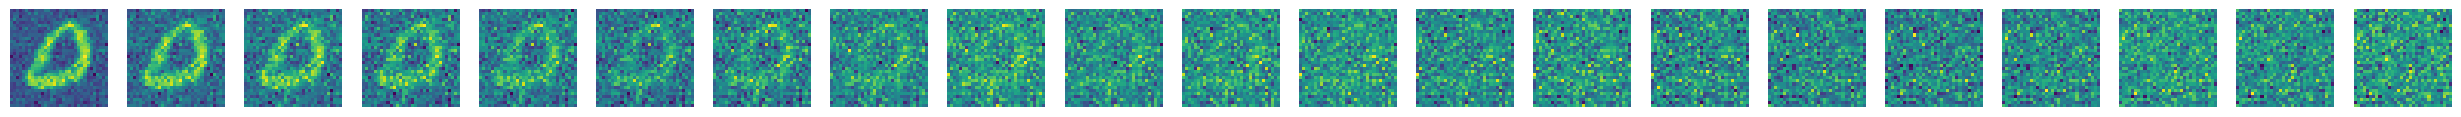

epoch: 95 batch: 1 | loss: 0.031329553574323654
epoch: 95 batch: 2 | loss: 0.014531043358147144
epoch: 95 batch: 3 | loss: 0.012796513736248016
epoch: 95 batch: 4 | loss: 0.017600249499082565
epoch: 95 batch: 5 | loss: 0.031330350786447525
epoch: 95 batch: 6 | loss: 0.01691805198788643
epoch: 95 batch: 7 | loss: 0.021277181804180145
epoch: 95 batch: 8 | loss: 0.010426176711916924
epoch: 95 batch: 9 | loss: 0.014101210981607437
epoch: 95 batch: 10 | loss: 0.022210998460650444
epoch: 95 batch: 11 | loss: 0.03290236368775368
epoch: 95 batch: 12 | loss: 0.010417318902909756
epoch: 95 batch: 13 | loss: 0.02251478098332882
epoch: 95 batch: 14 | loss: 0.01974763534963131
epoch: 95 batch: 15 | loss: 0.018659144639968872
epoch: 95 batch: 16 | loss: 0.011769931763410568
epoch: 95 batch: 17 | loss: 0.03561649098992348
epoch: 95 batch: 18 | loss: 0.24881614744663239
epoch: 95 batch: 19 | loss: 0.011348905973136425
epoch: 95 batch: 20 | loss: 0.011420462280511856
epoch: 95 batch: 21 | loss: 0.03742

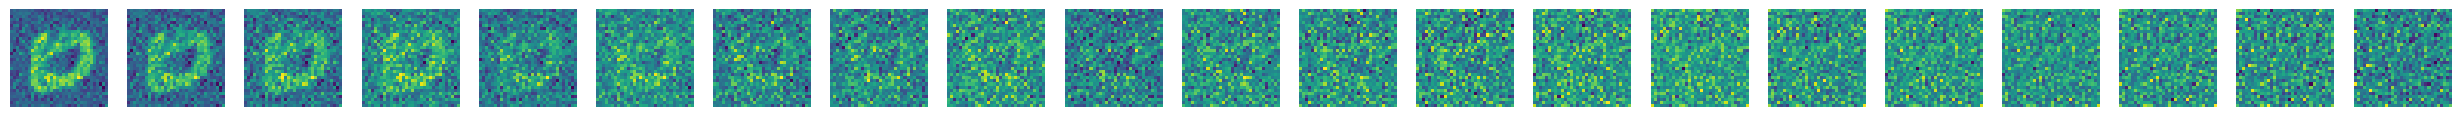

epoch: 96 batch: 1 | loss: 0.017811715602874756
epoch: 96 batch: 2 | loss: 0.015190288424491882
epoch: 96 batch: 3 | loss: 0.016096392646431923
epoch: 96 batch: 4 | loss: 0.009786240756511688
epoch: 96 batch: 5 | loss: 0.04704858362674713
epoch: 96 batch: 6 | loss: 0.05290970578789711
epoch: 96 batch: 7 | loss: 0.02752937376499176
epoch: 96 batch: 8 | loss: 0.023560035973787308
epoch: 96 batch: 9 | loss: 0.014098875224590302
epoch: 96 batch: 10 | loss: 0.012778901495039463
epoch: 96 batch: 11 | loss: 0.009725913405418396
epoch: 96 batch: 12 | loss: 0.04271318018436432
epoch: 96 batch: 13 | loss: 0.01571989804506302
epoch: 96 batch: 14 | loss: 0.013660266995429993
epoch: 96 batch: 15 | loss: 0.012002400122582912
epoch: 96 batch: 16 | loss: 0.03927040472626686
epoch: 96 batch: 17 | loss: 0.02255541831254959
epoch: 96 batch: 18 | loss: 0.026487059891223907
epoch: 96 batch: 19 | loss: 0.028521772474050522
epoch: 96 batch: 20 | loss: 0.018089313060045242
epoch: 96 batch: 21 | loss: 0.058767

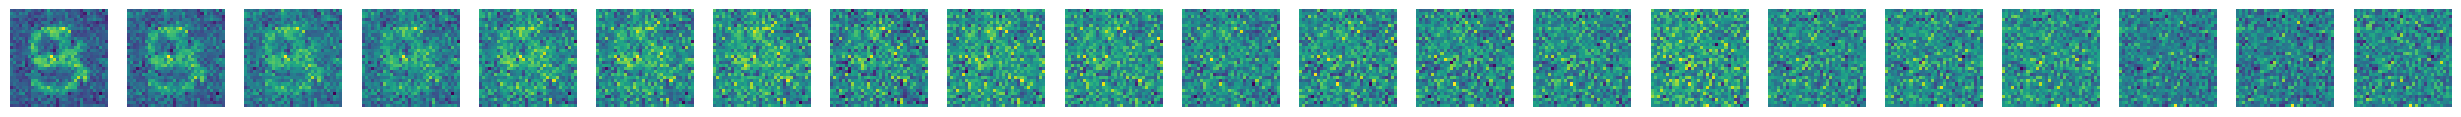

epoch: 97 batch: 1 | loss: 0.011514207348227501
epoch: 97 batch: 2 | loss: 0.015743505209684372
epoch: 97 batch: 3 | loss: 0.045998476445674896
epoch: 97 batch: 4 | loss: 0.03458993136882782
epoch: 97 batch: 5 | loss: 0.018008671700954437
epoch: 97 batch: 6 | loss: 0.057857614010572433
epoch: 97 batch: 7 | loss: 0.012099428102374077
epoch: 97 batch: 8 | loss: 0.02126171998679638
epoch: 97 batch: 9 | loss: 0.010516081005334854
epoch: 97 batch: 10 | loss: 0.019115354865789413
epoch: 97 batch: 11 | loss: 0.02380630187690258
epoch: 97 batch: 12 | loss: 0.022114483639597893
epoch: 97 batch: 13 | loss: 0.014912227168679237
epoch: 97 batch: 14 | loss: 0.018674854189157486
epoch: 97 batch: 15 | loss: 0.01781267113983631
epoch: 97 batch: 16 | loss: 0.015485475771129131
epoch: 97 batch: 17 | loss: 0.027432944625616074
epoch: 97 batch: 18 | loss: 0.011941656470298767
epoch: 97 batch: 19 | loss: 0.008582455106079578
epoch: 97 batch: 20 | loss: 0.02576536312699318
epoch: 97 batch: 21 | loss: 0.0082

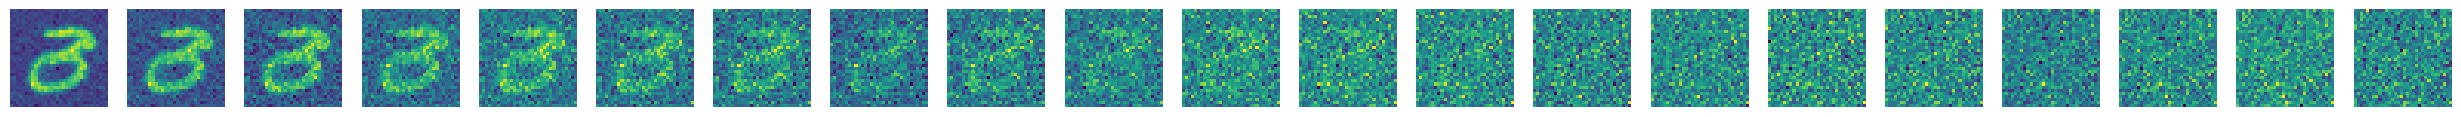

epoch: 98 batch: 1 | loss: 0.015843797475099564
epoch: 98 batch: 2 | loss: 0.017836224287748337
epoch: 98 batch: 3 | loss: 0.022329848259687424
epoch: 98 batch: 4 | loss: 0.028560321778059006
epoch: 98 batch: 5 | loss: 0.022057320922613144
epoch: 98 batch: 6 | loss: 0.0210958793759346
epoch: 98 batch: 7 | loss: 0.012128363363444805
epoch: 98 batch: 8 | loss: 0.010445764288306236
epoch: 98 batch: 9 | loss: 0.0516216978430748
epoch: 98 batch: 10 | loss: 0.01788221299648285
epoch: 98 batch: 11 | loss: 0.022394906729459763
epoch: 98 batch: 12 | loss: 0.015319890342652798
epoch: 98 batch: 13 | loss: 0.19424068927764893
epoch: 98 batch: 14 | loss: 0.016370024532079697
epoch: 98 batch: 15 | loss: 0.038251981139183044
epoch: 98 batch: 16 | loss: 0.010107997804880142
epoch: 98 batch: 17 | loss: 0.03662650287151337
epoch: 98 batch: 18 | loss: 0.017139803618192673
epoch: 98 batch: 19 | loss: 0.018307015299797058
epoch: 98 batch: 20 | loss: 0.09317541122436523
epoch: 98 batch: 21 | loss: 0.0204522

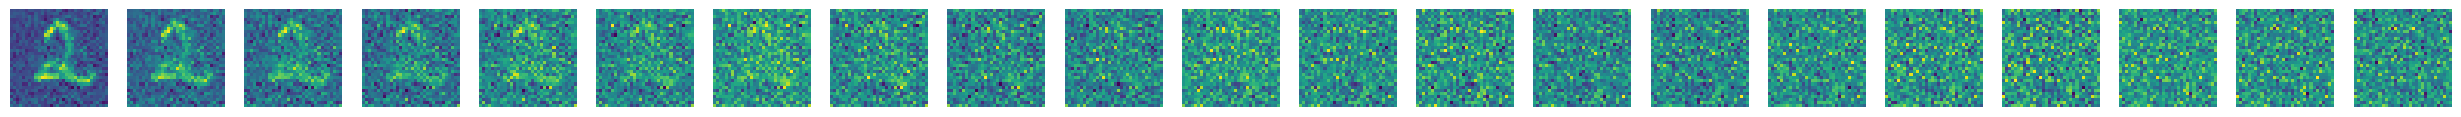

epoch: 99 batch: 1 | loss: 0.019440874457359314
epoch: 99 batch: 2 | loss: 0.014857899397611618
epoch: 99 batch: 3 | loss: 0.017902839928865433
epoch: 99 batch: 4 | loss: 0.03315674886107445
epoch: 99 batch: 5 | loss: 0.016390759497880936
epoch: 99 batch: 6 | loss: 0.030938707292079926
epoch: 99 batch: 7 | loss: 0.010567986406385899
epoch: 99 batch: 8 | loss: 0.03361018747091293
epoch: 99 batch: 9 | loss: 0.015162305906414986
epoch: 99 batch: 10 | loss: 0.030797259882092476
epoch: 99 batch: 11 | loss: 0.021280081942677498
epoch: 99 batch: 12 | loss: 0.027302797883749008
epoch: 99 batch: 13 | loss: 0.02956657111644745
epoch: 99 batch: 14 | loss: 0.018344875425100327
epoch: 99 batch: 15 | loss: 0.014160186983644962
epoch: 99 batch: 16 | loss: 0.01778578944504261
epoch: 99 batch: 17 | loss: 0.013371661305427551
epoch: 99 batch: 18 | loss: 0.028029249981045723
epoch: 99 batch: 19 | loss: 0.02155088633298874
epoch: 99 batch: 20 | loss: 0.14671456813812256
epoch: 99 batch: 21 | loss: 0.01820

In [10]:
# train the model
epoch = 100
for i in range(epoch):
    for s,x in enumerate(train_data):
        model.train()
        step = np.random.randint(1, T + 1)
        x = x.type(Type)
        noise, x = Add_Noise(x, step)
        x = Step_Emb(step, x)

        optimizer.zero_grad()
        eps = model(x)
        loss = F.mse_loss(eps, noise)
        loss.backward()
        optimizer.step()
    
        print(f"epoch: {i} batch: {s} | loss: {loss.item()}")
    
        # predict
        if(s % 500 == 0):
            model.eval()
            with torch.no_grad():
                tmp = torch.randn_like(train_data[0][0]).unsqueeze(0).type(Type)
                tmp = predict(tmp, model)

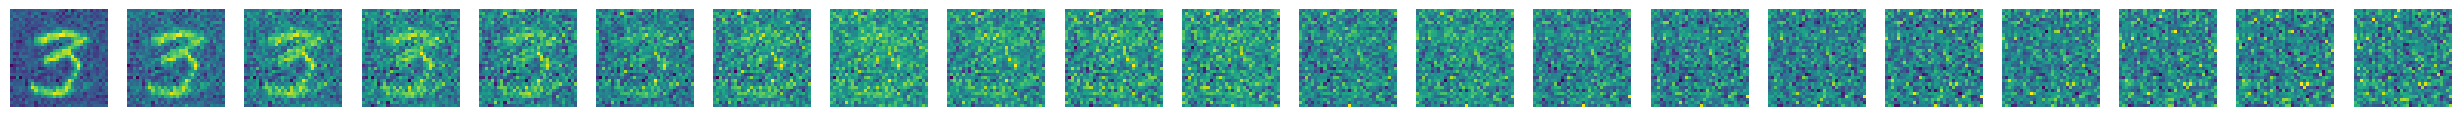

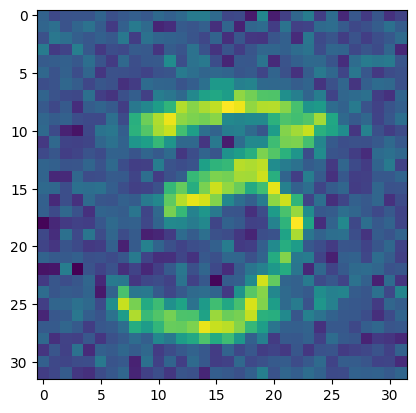

In [19]:
model.eval()
with torch.no_grad():
    tmp = torch.randn_like(train_data[0][0]).unsqueeze(0).type(Type)
    tmp = predict(tmp, model)
    plt.imshow(tmp[0].cpu().detach().numpy().transpose(1, 2, 0))
    plt.show()

# sample = train_data[0][0].unsqueeze(0).type(Type)
# # print(torch.max(sample), torch.min(sample))
# for i in range(T):
#     _, img = Add_Noise(sample, i + 1)
#     img = predict(img, model)


In [21]:
# save the model
torch.save(model.state_dict(), "model.pt")